# Model Comparison: First Attempt

In this notebook, six ML models:
1. NBC
2. RNN with Tokenizer
3. RNN with TextVectorization
4. BERT transformer with BertTokenizer
5. Logistic Regression with TfidfVectorizer
6. Support Vector Machine with TfidfVectorizer

are compared.

## Setup

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import torch
from transformers import BertTokenizer, BertForSequenceClassification

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import joblib
import sys
sys.path.append('../scripts')  # add the 'scripts' directory to sys.path
from word_normalization import preprocess_text  # for customized preprocessing

C:\Users\ASUS\anaconda3\envs\hexsoftwares_ml_env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f"CUDA version: {torch.version.cuda}")    
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f'Memory Usage: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

GPU: NVIDIA GeForce GTX 1060
CUDA version: 12.1
Number of GPUs: 1
Memory Usage: 6.00 GB
Using device: cuda


## Loading Test Datasets

In [3]:
df = pd.read_pickle('../datasets/final_testing_dataset.pkl')
df

,review_text,sentiment
0,fantast spot even quit cocktail swell host yel...,1
1,love love love calamari good spici endless lis...,1
2,love place stiff martini cocktail cheap drink ...,1
3,everyth great cocktail bar great locat ambianc...,1
4,come pirat game around 530ish even get lucki t...,1
...,...,...
4316,wife catch show golden nugget hear good thing ...,0
4317,dumb show ever seen never laugh minut realiz w...,0
4318,girlfriend go show absolut terriblenot funni n...,0
4319,restroom look like bombard improvis shack amid...,0


In [4]:
df2 = pd.read_csv('../datasets/a2_RestaurantReviews_FreshDump.tsv', delimiter = '\t', quoting = 3)
df2 = df2.dropna()
df2['Review'] = df2['Review'].progress_apply(lambda x: preprocess_text(x))
df2

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 144.07it/s]


,Review,sentiment
0,spend money elsewher,0
1,regular toast bread equal satisfi occasion pat...,1
2,buffet bellagio far anticip,0
3,drink weak peopl,0
4,order not correct,0
...,...,...
95,think food flavor textur lack,0
96,appetit instantli go,0
97,overal not impress would not go back,0
98,whole experi underwhelm think well go ninja su...,0


## Loading Models

There are two ways to use a trained model with unseen data:

1. **Modular**: Import the component that performs the vectorization, apply it to the unseen data, then import the model and use it on the vectorized unseen data.
    ```python
    count_vectorizer = joblib.load(<vectorizer only>)
    nbc = joblib.load(<model only>)
    ```

2. **All-in-one**: Import the object that already includes both the model and the vectorizer.
    ```python
    nbc = joblib.load(<GridCV that includes Pipeline that includes model and vectorizer>)
    ```

In [5]:
# model 1: NBC
nbc = joblib.load('../models/sentiment_analysis_nbc_model.joblib')

# model 2: RNN with Tokenizer
tokenizer = joblib.load("../text_transformers/tokenizer.pkl")
rnn_tokenizer = load_model("../models/sentiment_analysis_rnn_tokenizer_model.keras")

# model 3: RNN with TextVectorization
rnn_text_vectorization = load_model("../models/sentiment_analysis_rnn_textvectorization_model.keras")

# model 4: BERT transformer with BertTokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('../models/sentiment_analysis_bert_model_pytorch')
bert_model = bert_model.to(device)
bert_model.eval()  # set to evaluation mode

# model 5: logistic regression with TfidfVectorizer
logR = joblib.load("../models/sentiment_analysis_logr_model.joblib")

# model 6: SVM with TfidfVectorizer
svm = joblib.load("../models/sentiment_analysis_svm_model.joblib")

## Prediction on the First Test Dataset 

In [6]:
raw_X = df.review_text
raw_X

0       fantast spot even quit cocktail swell host yel...
1       love love love calamari good spici endless lis...
2       love place stiff martini cocktail cheap drink ...
3       everyth great cocktail bar great locat ambianc...
4       come pirat game around 530ish even get lucki t...
                              ...                        
4316    wife catch show golden nugget hear good thing ...
4317    dumb show ever seen never laugh minut realiz w...
4318    girlfriend go show absolut terriblenot funni n...
4319    restroom look like bombard improvis shack amid...
4320    go pennsylvania macaroni compani year love fre...
Name: review_text, Length: 4321, dtype: object

In [7]:
y_true = df.sentiment
y_true

0       1
1       1
2       1
3       1
4       1
       ..
4316    0
4317    0
4318    0
4319    0
4320    0
Name: sentiment, Length: 4321, dtype: int64

In [8]:
# NBC prediction
y_pred_nbc = nbc.predict(raw_X)

In [9]:
# RNN with Tokenizer prediction
X_sequences = tokenizer.texts_to_sequences(raw_X)
X_padded = pad_sequences(X_sequences, maxlen=80, padding='post')
prediction_probabilities_rnn_tok = rnn_tokenizer.predict(X_padded, verbose=0)
y_pred_rnn_tok = np.argmax(prediction_probabilities_rnn_tok, axis=1)

In [10]:
# RNN with TextVectorization prediction
prediction_probabilities_rnn_tv = rnn_text_vectorization.predict(
    tf.convert_to_tensor(raw_X), verbose=0
)
y_pred_rnn_tv = np.argmax(prediction_probabilities_rnn_tv, axis=1)

In [11]:
# function to predict with BERT in batches
def predict_bert_batch(texts, model, tokenizer, device, max_length=80, batch_size=32):
    """Predict sentiment for a batch of texts using BERT"""
    model.eval()
    predictions = []
    
    # process in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="   BERT batches"):
        batch_texts = texts[i:i+batch_size]
        
        # tokenize batch
        encodings = tokenizer.batch_encode_plus(
            batch_texts,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # move to device
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)
        
        # predict
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(batch_predictions)
    
    return np.array(predictions)


# BERT transformer with BertTokenizer prediction
MAX_LENGTH = 80  # BERT max sequence length
BERT_BATCH_SIZE = 32  # process in batches to avoid memory issues

y_pred_bert = predict_bert_batch(
    raw_X.tolist(), 
    bert_model, 
    bert_tokenizer, 
    device, 
    max_length=MAX_LENGTH,
    batch_size=BERT_BATCH_SIZE
)

   BERT batches: 100%|███████████████████████████████████████████████████████████████| 136/136 [00:53<00:00,  2.55it/s]


In [12]:
# logistic regression with TfidfVectorizer prediction
y_pred_logr = logR.predict(raw_X)

In [13]:
# SVM with TfidfVectorizer prediction
y_pred_svm = svm.predict(raw_X)

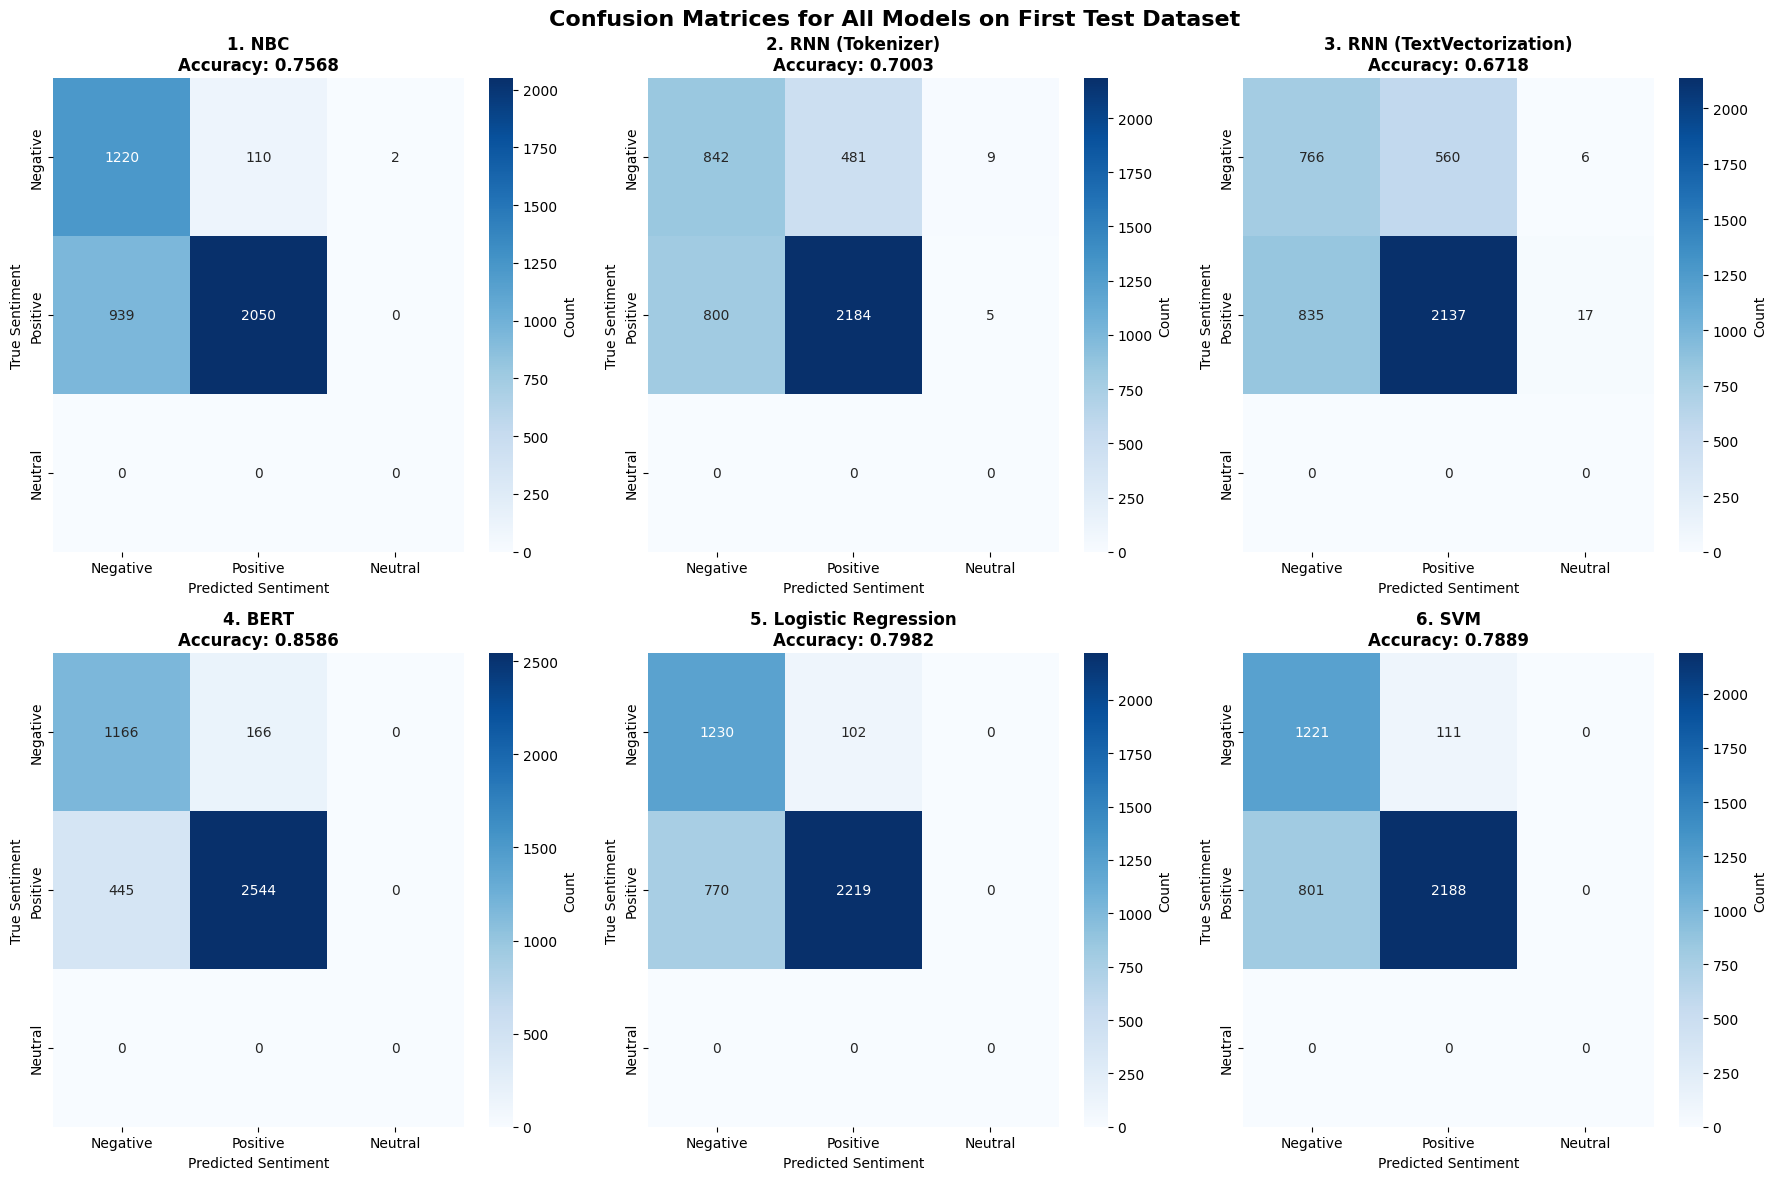

In [14]:
# confusion matrices for all models

## set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

## get unique labels for consistent plotting
labels = [0, 1, 2]
class_names = ['Negative', 'Positive', 'Neutral']

## create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices for All Models on First Test Dataset', fontsize=16, fontweight='bold')

## store all predictions and model names
predictions = {
    '1. NBC': y_pred_nbc,
    '2. RNN (Tokenizer)': y_pred_rnn_tok,
    '3. RNN (TextVectorization)': y_pred_rnn_tv,
    '4. BERT': y_pred_bert,
    '5. Logistic Regression': y_pred_logr,
    '6. SVM': y_pred_svm
}

## store all CMs
CMs = {}

## calculate and plot confusion matrices
row, col = 0, 0
for model_name, y_pred in predictions.items():
    ax = axes[row, col]
    
    # calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    CMs[model_name] = cm
    
    # calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # plot confusion matrix
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        ax=ax,
        cbar_kws={'label': 'Count'},
        xticklabels=class_names,
        yticklabels=class_names
    )
    
    # set title with accuracy
    ax.set_title(f'{model_name}\nAccuracy: {accuracy:.4f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Sentiment', fontsize=10)
    ax.set_ylabel('True Sentiment', fontsize=10)
    
    # move to next subplot
    col += 1
    if col == 3:
        col = 0
        row += 1

plt.tight_layout()
plt.show()

In [15]:
# summary statistics
for model_name, y_pred in predictions.items():
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name}:")
    print(f"\tAccuracy: {accuracy:.4f}")


1. NBC:
	Accuracy: 0.7568

2. RNN (Tokenizer):
	Accuracy: 0.7003

3. RNN (TextVectorization):
	Accuracy: 0.6718

4. BERT:
	Accuracy: 0.8586

5. Logistic Regression:
	Accuracy: 0.7982

6. SVM:
	Accuracy: 0.7889


## Prediction on the Second Test Dataset 

In [16]:
raw_X = df2.Review
raw_X

0                                  spend money elsewher
1     regular toast bread equal satisfi occasion pat...
2                           buffet bellagio far anticip
3                                      drink weak peopl
4                                     order not correct
                            ...                        
95                        think food flavor textur lack
96                                 appetit instantli go
97                 overal not impress would not go back
98    whole experi underwhelm think well go ninja su...
99    have not wast enough life pour salt wound draw...
Name: Review, Length: 100, dtype: object

In [17]:
y_true = df2.sentiment
y_true

0     0
1     1
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Name: sentiment, Length: 100, dtype: int64

In [18]:
# NBC prediction
y_pred_nbc = nbc.predict(raw_X)

In [19]:
# RNN with Tokenizer prediction
X_sequences = tokenizer.texts_to_sequences(raw_X)
X_padded = pad_sequences(X_sequences, maxlen=80, padding='post')
prediction_probabilities_rnn_tok = rnn_tokenizer.predict(X_padded, verbose=0)
y_pred_rnn_tok = np.argmax(prediction_probabilities_rnn_tok, axis=1)

In [20]:
# RNN with TextVectorization prediction
prediction_probabilities_rnn_tv = rnn_text_vectorization.predict(
    tf.convert_to_tensor(raw_X), verbose=0
)
y_pred_rnn_tv = np.argmax(prediction_probabilities_rnn_tv, axis=1)

In [21]:
# BERT transformer with BertTokenizer prediction
y_pred_bert = predict_bert_batch(
    raw_X.tolist(), 
    bert_model, 
    bert_tokenizer, 
    device, 
    max_length=MAX_LENGTH,
    batch_size=BERT_BATCH_SIZE
)

   BERT batches: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.65it/s]


In [22]:
# logistic regression with TfidfVectorizer prediction
y_pred_logr = logR.predict(raw_X)

In [23]:
# SVM with TfidfVectorizer prediction
y_pred_svm = svm.predict(raw_X)

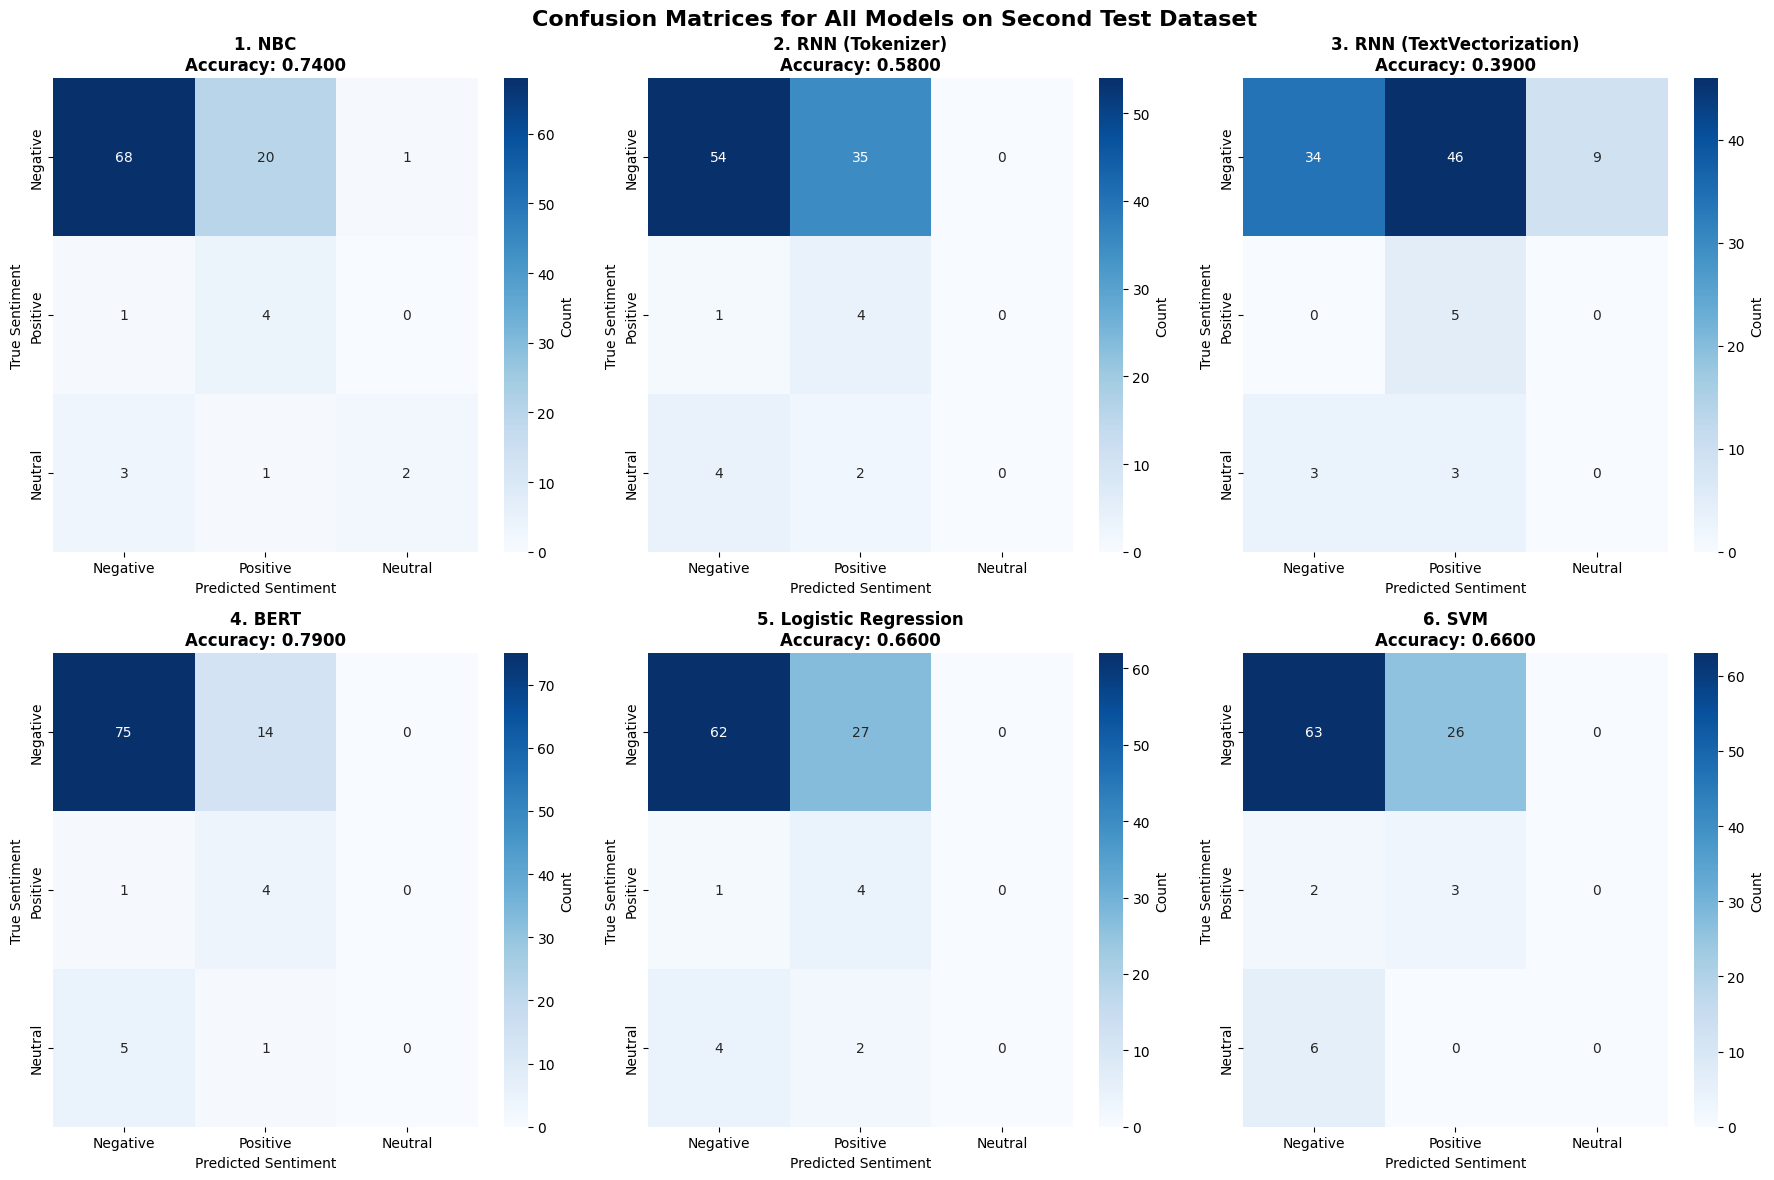

In [24]:
# confusion matrices for all models

## create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices for All Models on Second Test Dataset', fontsize=16, fontweight='bold')

## store all predictions and model names
predictions = {
    '1. NBC': y_pred_nbc,
    '2. RNN (Tokenizer)': y_pred_rnn_tok,
    '3. RNN (TextVectorization)': y_pred_rnn_tv,
    '4. BERT': y_pred_bert,
    '5. Logistic Regression': y_pred_logr,
    '6. SVM': y_pred_svm
}

## store all CMs
CMs2 = {}

## calculate and plot confusion matrices
row, col = 0, 0
for model_name, y_pred in predictions.items():
    ax = axes[row, col]
    
    # calculate confusion matrix
    cm2 = confusion_matrix(y_true, y_pred, labels=labels)
    CMs2[model_name] = cm2
    
    # calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # plot confusion matrix
    sns.heatmap(
        cm2, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        ax=ax,
        cbar_kws={'label': 'Count'},
        xticklabels=class_names,
        yticklabels=class_names
    )
    
    # set title with accuracy
    ax.set_title(f'{model_name}\nAccuracy: {accuracy:.4f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Sentiment', fontsize=10)
    ax.set_ylabel('True Sentiment', fontsize=10)
    
    # move to next subplot
    col += 1
    if col == 3:
        col = 0
        row += 1

plt.tight_layout()
plt.show()

In [25]:
# summary statistics
for model_name, y_pred in predictions.items():
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name}:")
    print(f"\tAccuracy: {accuracy:.4f}")


1. NBC:
	Accuracy: 0.7400

2. RNN (Tokenizer):
	Accuracy: 0.5800

3. RNN (TextVectorization):
	Accuracy: 0.3900

4. BERT:
	Accuracy: 0.7900

5. Logistic Regression:
	Accuracy: 0.6600

6. SVM:
	Accuracy: 0.6600


## Insight

The following facts are already known:
- Each model has been trained with 3 classes from the chosen training dataset.
- The class distribution within the chosen training dataset is not uniform.
- The first test dataset, which is chosen as the currently final testing dataset, contains only 2 classes.
- The second test dataset also has very limited entries, so it is not a good representative sample either.
- The average word-count-per-sentence after preprocessing is around 3-4, with a maximum of 19 in the current final training dataset.
- The average word-count-per-sentence after preprocessing is around 65, with a maximum of 472 in the current final testing dataset (the first test dataset).

Despite the dataset distribution challenges, after comparing each model in this notebook, it is BERT that performs the best on both test datasets, outperforming all other models.

**A hypothesis is made: the models may perform better if they are to use aggregated prediction.** This technique involves splitting a long sentence into smaller chunks (typically 4 words per chunk), predicting the sentiment probability distribution for each chunk separately, averaging the probability distributions across all chunks to obtain a single aggregated probability vector, and finally taking the argmax of this averaged vector to determine the final prediction. This approach could be particularly beneficial for handling long sentences that exceed the typical training sequence length, as it would allow the model to process the sentence in manageable segments and combine their predictions, potentially capturing sentiment nuances that might be lost when processing the entire sentence at once.

This notebook is done by `La Wun Nannda`.